### Import relevant libraries

In [49]:
from semopy import Model, calc_stats, semplot
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import pandas as pd
import numpy as np
import seaborn as sns
from semopy.inspector import inspect


### Import the dataset

In [50]:
df = pd.read_csv("Welzijnsmonitor2025_scaled_normalised_UTF8.csv", sep=";")

### Looking for correlations between variables

In [51]:
numeric_cols = [col for col in df if pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col])]

# Compute correlation matrix for numeric columns
corr_matrix = df[numeric_cols].corr()

# Take only upper triangle (no self- or duplicate pairs)
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Turn into a Series of pairs and filter |corr| > 0.7
high_corr_pairs = (
    upper
    .stack()                       # (col1, col2) index, correlation as values
    .rename("correlation")
)

# Keep only strong correlations and sort by |correlation|
high_corr_pairs = high_corr_pairs[
    high_corr_pairs.abs() > 0.7
].sort_values(key=lambda s: s.abs(), ascending=False)

print(high_corr_pairs)

StudentID    Bekendgebruik_1    0.848417
Extr_eng2_2  Extr_eng2_3        0.705477
Name: correlation, dtype: float64


### Creating the model

In [52]:
model_desc_order1 = """
Engagement_and_Burnout_1 =~ Bevl_1 + Bevl_2 + Bevl_3
Behavior_1 =~ Cogn_Eng1_5 + Cogn_Eng1_6 + Cogn_Eng2_2 + Cogn_Eng2_3 + Cogn_Eng2_8
Motivation =~ Mot_Stress_1 + Mot_Stress_4
Resilience_1 =~ Veer_1 + Veer_5

Knowledge_of_Interventions =~ Bekendgebruik_1 + Bekendgebruik_2 + Bekendgebruik_3 + Bekendgebruik_4 + Bekendgebruik_5 + Bekendgebruik_6 + Bekendgebruik_7
Behavior_2 =~ Cogn_Eng1_1 + Cogn_Eng1_2 + Cogn_Eng1_3 + Cogn_Eng1_4 + Cogn_Eng2_1 + Cogn_Eng2_4 + Cogn_Eng2_5 + Cogn_Eng2_6 + Cogn_Eng2_7
Extra_Engagement =~ Cogregiedocent_1 + Cogregiedocent_2 + Cogregiedocent_3 +  Cogregiedocent_4 + Cogregiedocent_5 + Cogregiedocent_6 + Extr_eng2_1 + Extr_eng2_2 + Extr_eng2_3
Need_for_Help =~ Hulp_1 + Hulp_2 + Hulp_3
Participation =~ Partici1_1 + Partici1_2 + Partici1_3 + Partici1_4

Study_Performance =~ Cijfer_huidig_1 + StPunt_beh
Lifestyle =~ Cantrill_1 + Leefst + Q297_1
Stress_1 =~ Onnodige_stress_1 + Onnodige_stress_2 + Onnodige_stress_3 + Onnodige_stress_4 + Onnodige_stress_5 + Onnodige_stress_6 + Onnodige_stress_7 + Onnodige_stress_8 + Onnodige_stress_9 + Onnodige_stress_10
Pressure_to_Perform =~ Pres_1 + Pres_2 + Pres_12
Anxiety =~ Zorg_1 + Zorg_2 + Zorg_3 + Zorg_4 + Zorg_5 + Zorg_6

Engagement_and_Burnout_2 =~ Burn1_1 + Burn1_2 + Burn1_3 + Burn1_4
Depression =~ Depr_1 + Depr_2 + Depr_3 + Depr_4 + Depr_5 + Depr_6 + Depr_7 + Depr_8
Resilience_2 =~ Veer_2 + Veer_3 + Veer_4 + Veer_6
"""

In [53]:

m1 = Model(model_desc_order1)
m1.fit(df)

first_order_scores = m1.predict_factors(df)

### Export the model with the new latent variables

In [54]:
latent_scores = m1.predict_factors(df)

latent_scores.to_csv("latent_variable_scores.csv", index=False)

print("Latent variable scores extracted:")
print(latent_scores.head())

Latent variable scores extracted:
    Anxiety  Behavior_1  Behavior_2  Depression  Engagement_and_Burnout_1  \
0  0.358760   -0.233713   -0.024178   -0.246092                  0.350744   
1 -0.667037   -0.683079   -0.406280   -0.980312                  0.012691   
2 -0.735243    0.278331    0.008879   -0.288959                  0.448578   
3 -0.554259   -0.422547   -0.221635   -0.746325                 -0.077319   
4  0.976405   -0.462138   -0.142406    1.461245                  0.057532   

   Engagement_and_Burnout_2  Extra_Engagement  Knowledge_of_Interventions  \
0                 -0.225727         -0.025391                   -0.246220   
1                 -0.794171         -0.016873                   -0.252440   
2                 -0.521472          0.074018                   -0.285581   
3                 -0.324128         -0.087277                   -0.263890   
4                  0.533168         -0.015003                   -0.248118   

   Lifestyle  Motivation  Need_for_Help 

### Create a minmax normalization for latent variables (Temporary solution)

In [55]:
scaler = MinMaxScaler()

latent_scores_normalized = pd.DataFrame(
    scaler.fit_transform(latent_scores),
    columns=latent_scores.columns,
    index=latent_scores.index
)

### Building second order of the model

In [56]:
# Use normalized latent scores to build broader second-order constructs
ls = latent_scores_normalized  # shorthand

second_order_scores = pd.DataFrame(index=ls.index)

# Wellbeing: from first-order wellbeing-related factors
second_order_scores["Wellbeing"] = ls[[
    "Engagement_and_Burnout_1",
    "Behavior_1",
    "Motivation",
    "Resilience_1"
]].mean(axis=1)

# Energy Sources
second_order_scores["Energy_Sources"] = ls[[
    "Knowledge_of_Interventions",
    "Behavior_2",
    "Extra_Engagement",
    "Need_for_Help",
    "Participation"
]].mean(axis=1)

# Stressors
second_order_scores["Stressors"] = ls[[
    "Lifestyle",
    "Stress_1",
    "Pressure_to_Perform",
    "Anxiety"
]].mean(axis=1)

# Response to Stress
second_order_scores["Response_to_Stress"] = ls[[
    "Engagement_and_Burnout_2",
    "Depression",
    "Resilience_2"
]].mean(axis=1)

# Outcomes (built from observed variables in df)
second_order_scores["Negative_Outcomes"] = df[["StopInt", "Vertr"]].mean(axis=1)
second_order_scores["Positive_Outcomes"] = df["Stopint2"]

In [57]:
df_with_latent_norm = df.copy()
for col in latent_scores_normalized.columns:
    df_with_latent_norm[col + "_norm"] = latent_scores_normalized[col]

# Save if needed
df_with_latent_norm.to_csv("data_with_normalized_latent_variables.csv", index=False)

In [58]:
for col in second_order_scores.columns:
    df_with_latent_norm[col] = second_order_scores[col]

df_with_latent_norm.to_csv("data_with_first_and_second_order_latent_vars.csv", index=False)

### Calculate fit indices

In [59]:
stats = calc_stats(m1)

print("=== Model Fit Statistics ===")
print(stats.T)

=== Model Fit Statistics ===
                      Value
DoF             3266.000000
DoF Baseline    3486.000000
chi2           16490.432198
chi2 p-value       0.000000
chi2 Baseline  53450.991485
CFI                0.735326
GFI                0.691485
AGFI               0.670703
NFI                0.691485
TLI                0.717497
RMSEA              0.051749
AIC              586.201676
BIC             2204.043989
LogLik            10.899162


### Create the diagram

In [60]:
g = semplot(m1, "pd.png")
print(g)

digraph G {
	overlap=scale splines=true
	edge [fontsize=12]
	node [fillcolor="#cae6df" shape=circle style=filled]
	Resilience_1 [label=Resilience_1]
	Extra_Engagement [label=Extra_Engagement]
	Need_for_Help [label=Need_for_Help]
	Anxiety [label=Anxiety]
	Resilience_2 [label=Resilience_2]
	Study_Performance [label=Study_Performance]
	Behavior_2 [label=Behavior_2]
	Pressure_to_Perform [label=Pressure_to_Perform]
	Lifestyle [label=Lifestyle]
	Participation [label=Participation]
	Motivation [label=Motivation]
	Knowledge_of_Interventions [label=Knowledge_of_Interventions]
	Engagement_and_Burnout_2 [label=Engagement_and_Burnout_2]
	Depression [label=Depression]
	Engagement_and_Burnout_1 [label=Engagement_and_Burnout_1]
	Stress_1 [label=Stress_1]
	Behavior_1 [label=Behavior_1]
	node [shape=box style=""]
	Bekendgebruik_1 [label=Bekendgebruik_1]
	Bekendgebruik_2 [label=Bekendgebruik_2]
	Bekendgebruik_3 [label=Bekendgebruik_3]
	Bekendgebruik_4 [label=Bekendgebruik_4]
	Bekendgebruik_5 [label=Beke

In [61]:
model_desc_struct = """
Engagement_and_Burnout_1 =~ Bevl_1 + Bevl_2 + Bevl_3
Behavior_1 =~ Cogn_Eng1_5 + Cogn_Eng1_6 + Cogn_Eng2_2 + Cogn_Eng2_3 + Cogn_Eng2_8
Motivation =~ Mot_Stress_1 + Mot_Stress_4
Resilience_1 =~ Veer_1 + Veer_5

Knowledge_of_Interventions =~ Bekendgebruik_1 + Bekendgebruik_2 + Bekendgebruik_3 + Bekendgebruik_4 + Bekendgebruik_5 + Bekendgebruik_6 + Bekendgebruik_7
Behavior_2 =~ Cogn_Eng1_1 + Cogn_Eng1_2 + Cogn_Eng1_3 + Cogn_Eng1_4 + Cogn_Eng2_1 + Cogn_Eng2_4 + Cogn_Eng2_5 + Cogn_Eng2_6 + Cogn_Eng2_7
Extra_Engagement =~ Cogregiedocent_1 + Cogregiedocent_2 + Cogregiedocent_3 +  Cogregiedocent_4 + Cogregiedocent_5 + Cogregiedocent_6 + Extr_eng2_1 + Extr_eng2_2 + Extr_eng2_3
Need_for_Help =~ Hulp_1 + Hulp_2 + Hulp_3
Participation =~ Partici1_1 + Partici1_2 + Partici1_3 + Partici1_4

Study_Performance =~ Cijfer_huidig_1 + StPunt_beh
Lifestyle =~ Cantrill_1 + Leefst + Q297_1
Stress_1 =~ Onnodige_stress_1 + Onnodige_stress_2 + Onnodige_stress_3 + Onnodige_stress_4 + Onnodige_stress_5 + Onnodige_stress_6 + Onnodige_stress_7 + Onnodige_stress_8 + Onnodige_stress_9 + Onnodige_stress_10
Pressure_to_Perform =~ Pres_1 + Pres_2 + Pres_12
Anxiety =~ Zorg_1 + Zorg_2 + Zorg_3 + Zorg_4 + Zorg_5 + Zorg_6

Engagement_and_Burnout_2 =~ Burn1_1 + Burn1_2 + Burn1_3 + Burn1_4
Depression =~ Depr_1 + Depr_2 + Depr_3 + Depr_4 + Depr_5 + Depr_6 + Depr_7 + Depr_8
Resilience_2 =~ Veer_2 + Veer_3 + Veer_4 + Veer_6

# -------- Order 2 --------
Wellbeing         =~ Engagement_and_Burnout_1 + Behavior_1 + Motivation + Resilience_1
Energy_Sources    =~ Knowledge_of_Interventions + Behavior_2 + Extra_Engagement + Need_for_Help + Participation + Betrok_Ouders
Negative_Outcomes =~ StopInt + Vertr
Positive_Outcomes =~ Study_Performance + Stopint2
Stressors         =~ Lifestyle + Stress_1 + Pressure_to_Perform + Anxiety + Werk_1
Response_to_Stress =~ Engagement_and_Burnout_2 + Depression + Resilience_2 + Mot_Stress_2

# Covariances (two-headed arrows in the diagram)
Stressors ~~ Energy_Sources
Response_to_Stress ~~ Wellbeing

# Directed paths
Response_to_Stress ~ Stressors + Energy_Sources
Wellbeing        ~ Stressors + Energy_Sources

Negative_Outcomes ~ Response_to_Stress + Wellbeing
Positive_Outcomes ~ Response_to_Stress + Wellbeing
"""

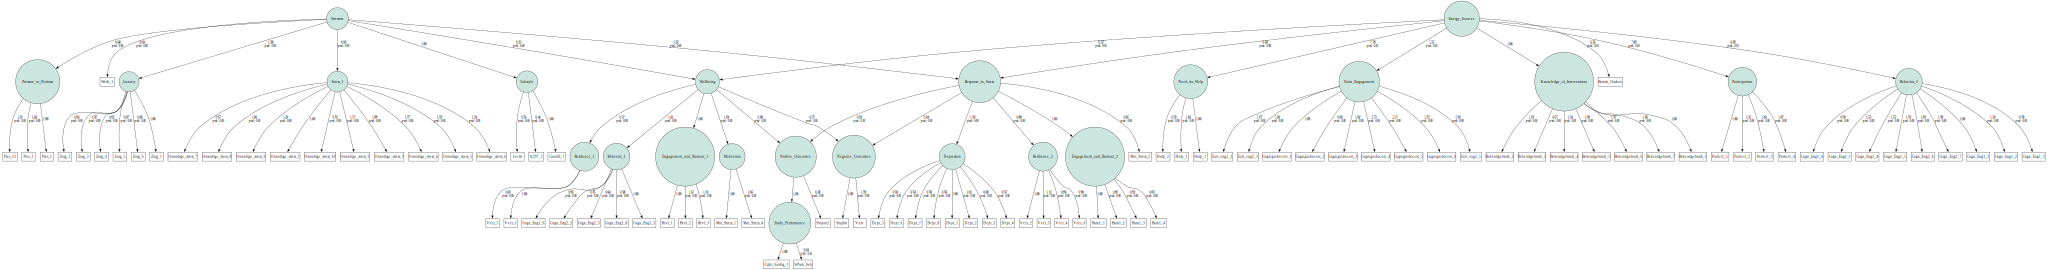

In [62]:
m2 = Model(model_desc_struct)
m2.fit(df)
semplot(m2, "model_second_order.png")

In [63]:
# Wellbeing =~ Engagement_and_Burnout_1 + Behavior_1 + Motivation + Resilience_1
# Energy_Sources =~ Knowledge_of_Interventions + Betrok_Ouders + Behavior_2 + Extra_Engagement + Need_for_Help + Participation
# Negative_Outcomes =~ StopInt + Vertr
# Positive_Outcomes =~ Study_Performance + Stopint2
# Stressors =~ Lifestyle + Stress_1 + Pressure_to_Perform + Werk_1 + Anxiety
# Response_to_Stress =~ Engagement_and_Burnout_2 + Depression + Mot_Stress_2 + Resilience_2
# regressions
# Stressors ~ Energy_Sources
# Energy_Sources ~ Stressors

# Response_to_Stress ~ Stressors + Energy_Sources + Wellbeing
# Wellbeing ~ Stressors + Energy_Sources + Response_to_Stress

# Positive_Outcomes ~ Wellbeing + Response_to_Stress
# Negative_Outcomes ~ Wellbeing + Response_to_Stress